In [52]:
import pandas as pd
import random
import numpy as np
import math
import seaborn as sns
from datetime import date
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import six
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

In [53]:
data = pd.read_csv('HMXPC13_DI_v2_5-14-14.csv')

In [54]:
data.head(5)

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts,roles,incomplete_flag
0,HarvardX/CB22x/2013_Spring,MHxPC130442623,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,2013-11-17,NaN,9.0,NaN,NaN,0,NaN,1.0
1,HarvardX/CS50x/2012,MHxPC130442623,1,1,0,0,United States,NaN,NaN,NaN,0,2012-10-15,NaN,NaN,9.0,NaN,1.0,0,NaN,1.0
2,HarvardX/CB22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2013-02-08,2013-11-17,NaN,16.0,NaN,NaN,0,NaN,1.0
3,HarvardX/CS50x/2012,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2012-09-17,NaN,NaN,16.0,NaN,NaN,0,NaN,1.0
4,HarvardX/ER22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,NaN,NaN,16.0,NaN,NaN,0,NaN,1.0


In [55]:
data.columns

Index(['course_id', 'userid_DI', 'registered', 'viewed', 'explored',
       'certified', 'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade',
       'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video',
       'nchapters', 'nforum_posts', 'roles', 'incomplete_flag'],
      dtype='object')

In [56]:
data.shape

(641138, 20)

In [57]:
data = data.drop(['roles', 'incomplete_flag' , 'registered'], axis=1) #We are dropping 3 columns: registered becasue it has only
#value 1 and nothing else; incoplete flag and roles because they have mostly Null values and are only used for administration

#### Considering that all 4 tested columns have no value 0 we will now assign 0 to all rows that have NaN value

In [58]:
data['nevents'].fillna(0.0, inplace = True)

In [59]:
data['ndays_act'].fillna(0.0, inplace = True)

In [60]:
data['nplay_video'].fillna(0.0, inplace = True)

In [61]:
data['nchapters'].fillna(0.0, inplace = True)

In [62]:

data.head(5)

,course_id,userid_DI,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CB22x/2013_Spring,MHxPC130442623,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,2013-11-17,0.0,9.0,0.0,0.0,0
1,HarvardX/CS50x/2012,MHxPC130442623,1,0,0,United States,NaN,NaN,NaN,0,2012-10-15,NaN,0.0,9.0,0.0,1.0,0
2,HarvardX/CB22x/2013_Spring,MHxPC130275857,0,0,0,United States,NaN,NaN,NaN,0,2013-02-08,2013-11-17,0.0,16.0,0.0,0.0,0
3,HarvardX/CS50x/2012,MHxPC130275857,0,0,0,United States,NaN,NaN,NaN,0,2012-09-17,NaN,0.0,16.0,0.0,0.0,0
4,HarvardX/ER22x/2013_Spring,MHxPC130275857,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,NaN,0.0,16.0,0.0,0.0,0


#### Transforming Country of origin data using get_dummies function - Converts categorical variable into dummy/indicator variables

In [63]:
data = data.join(pd.get_dummies(data['final_cc_cname_DI']))

In [64]:
data.columns

Index(['course_id', 'userid_DI', 'viewed', 'explored', 'certified',
       'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade',
       'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video',
       'nchapters', 'nforum_posts', 'Australia', 'Bangladesh', 'Brazil',
       'Canada', 'China', 'Colombia', 'Egypt', 'France', 'Germany', 'Greece',
       'India', 'Indonesia', 'Japan', 'Mexico', 'Morocco', 'Nigeria',
       'Other Africa', 'Other East Asia', 'Other Europe',
       'Other Middle East/Central Asia',
       'Other North & Central Amer., Caribbean', 'Other Oceania',
       'Other South America', 'Other South Asia', 'Pakistan', 'Philippines',
       'Poland', 'Portugal', 'Russian Federation', 'Spain', 'Ukraine',
       'United Kingdom', 'United States', 'Unknown/Other'],
      dtype='object')

When the date is missing from the column "last_event_DI" this means that there was no interaction with the course after enrolment. Considering this we have decided to put starting date as the date of last interaction instead of NaN value. This way we keep all entries and we get 0 days active.

In [65]:
data["last_event_DI"] = data.apply(lambda x: x.start_time_DI if pd.isnull(x.last_event_DI) else x.last_event_DI, axis =1)

In [66]:
data[['course_id','userid_DI', 'start_time_DI', 'last_event_DI', 'ndays_act']].head(5)

,course_id,userid_DI,start_time_DI,last_event_DI,ndays_act
0,HarvardX/CB22x/2013_Spring,MHxPC130442623,2012-12-19,2013-11-17,9.0
1,HarvardX/CS50x/2012,MHxPC130442623,2012-10-15,2012-10-15,9.0
2,HarvardX/CB22x/2013_Spring,MHxPC130275857,2013-02-08,2013-11-17,16.0
3,HarvardX/CS50x/2012,MHxPC130275857,2012-09-17,2012-09-17,16.0
4,HarvardX/ER22x/2013_Spring,MHxPC130275857,2012-12-19,2012-12-19,16.0


We have checked the type of all dates entered in columnes "start_time_DI" and "last_event_DI" and they are all String. The for loop that we used is removed from the code as it takes long time to run.
#### We now make a derivative columne that shows "monts active" and it is determined from start time of the course and last event
To work with dates, we need to convert them from strings into a data format built for processing dates. The pandas library comes with a Timestamp data object for storing and working with dates.

In [67]:
data["start_time_DI"] = pd.to_datetime(data["start_time_DI"] )

In [68]:
data["last_event_DI"] = pd.to_datetime(data["last_event_DI"] ) 

In [69]:
data['days_active'] = data['last_event_DI'] - data['start_time_DI']

In [70]:
data['days_active'] = data['days_active'].apply(lambda x: x.days)

In [71]:
data.columns

Index(['course_id', 'userid_DI', 'viewed', 'explored', 'certified',
       'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade',
       'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video',
       'nchapters', 'nforum_posts', 'Australia', 'Bangladesh', 'Brazil',
       'Canada', 'China', 'Colombia', 'Egypt', 'France', 'Germany', 'Greece',
       'India', 'Indonesia', 'Japan', 'Mexico', 'Morocco', 'Nigeria',
       'Other Africa', 'Other East Asia', 'Other Europe',
       'Other Middle East/Central Asia',
       'Other North & Central Amer., Caribbean', 'Other Oceania',
       'Other South America', 'Other South Asia', 'Pakistan', 'Philippines',
       'Poland', 'Portugal', 'Russian Federation', 'Spain', 'Ukraine',
       'United Kingdom', 'United States', 'Unknown/Other', 'days_active'],
      dtype='object')

#### Dealing with NaN values and transforming Year of birth so we can have new column "age"

In [72]:
#data['YoB'].fillna(int(data['YoB'].mean()), inplace = True) #for missing values we set mean of all ages - temporary solution

In [73]:
data['YoB'].fillna(random.choice(range(int(data['YoB'].min()), int(data['YoB'].max()))), inplace = True)

In [74]:
data['YoB'].value_counts(dropna = False)

2003.0    96615
1990.0    38524
1992.0    37846
1991.0    37544
1989.0    36831
1988.0    34436
1993.0    33999
1987.0    31313
1986.0    28725
1985.0    25539
1994.0    23921
1984.0    22138
1983.0    18869
1982.0    16867
1981.0    14477
1995.0    13806
1980.0    13806
1979.0    10954
1978.0     9383
1977.0     8312
1996.0     7754
1976.0     7131
1975.0     6174
1974.0     5596
1973.0     4740
1972.0     4493
1997.0     4082
1970.0     4075
1971.0     3878
1969.0     3296
          ...  
1952.0      678
1951.0      667
1950.0      656
1949.0      500
2012.0      472
1947.0      460
1948.0      365
2000.0      340
1946.0      331
1943.0      223
1944.0      221
1945.0      216
1942.0      196
2001.0      142
1941.0       96
1940.0       92
1939.0       86
1938.0       74
1937.0       64
2013.0       61
2002.0       45
1936.0       43
1935.0       36
2011.0       34
2010.0       17
2008.0       10
2009.0        8
1931.0        7
2007.0        6
1934.0        5
Name: YoB, Length: 78, d

In [75]:
now = datetime.datetime.now()

In [76]:
data['age'] = data['YoB'].apply(lambda x: now.year - int(x)) # we use provided year of birth to calculate
#age of all participants and save it as new column

#### Dealing with NaN values and converting Level of education from categorical variable into indicator variables

In [77]:
data['LoE_DI'] = data['LoE_DI'].fillna('UnknownLoE') #temporary solution

In [78]:
data['LoE_DI'].value_counts(dropna= False)

Bachelor's             219768
Secondary              169694
Master's               118189
UnknownLoE             106008
Less than Secondary     14092
Doctorate               13387
Name: LoE_DI, dtype: int64

In [79]:
data = data.join(pd.get_dummies(data['LoE_DI']))

#### Dealing with NaN values and converting Gender from categorical variable into indicator variables

In [80]:
data['gender'].value_counts(dropna= False)

m      411520
f      142795
NaN     86806
o          17
Name: gender, dtype: int64

In [81]:
data['gender'].fillna('u', inplace = True) #changing NaN values to 'u' -unknown - temporary solution

In [82]:
data = data.join(pd.get_dummies(data['gender']))

In [83]:
data.columns

Index(['course_id', 'userid_DI', 'viewed', 'explored', 'certified',
       'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade',
       'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video',
       'nchapters', 'nforum_posts', 'Australia', 'Bangladesh', 'Brazil',
       'Canada', 'China', 'Colombia', 'Egypt', 'France', 'Germany', 'Greece',
       'India', 'Indonesia', 'Japan', 'Mexico', 'Morocco', 'Nigeria',
       'Other Africa', 'Other East Asia', 'Other Europe',
       'Other Middle East/Central Asia',
       'Other North & Central Amer., Caribbean', 'Other Oceania',
       'Other South America', 'Other South Asia', 'Pakistan', 'Philippines',
       'Poland', 'Portugal', 'Russian Federation', 'Spain', 'Ukraine',
       'United Kingdom', 'United States', 'Unknown/Other', 'days_active',
       'age', 'Bachelor's', 'Doctorate', 'Less than Secondary', 'Master's',
       'Secondary', 'UnknownLoE', 'f', 'm', 'o', 'u'],
      dtype='object')

In [84]:
data.shape

(641138, 63)

In [85]:
data = data.loc[data['grade'] != " ",] #some grades are empty string (space) and we drop those rows

In [86]:
data.dropna(axis=0, inplace=True) #only remaining NaN values are the once where there is a grade missing and we choose to drop

In [87]:
data['grade'] = data['grade'].astype(float)

In [88]:
data.shape #we lost 57400 rows

(583738, 63)

In [89]:
data.columns

Index(['course_id', 'userid_DI', 'viewed', 'explored', 'certified',
       'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade',
       'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video',
       'nchapters', 'nforum_posts', 'Australia', 'Bangladesh', 'Brazil',
       'Canada', 'China', 'Colombia', 'Egypt', 'France', 'Germany', 'Greece',
       'India', 'Indonesia', 'Japan', 'Mexico', 'Morocco', 'Nigeria',
       'Other Africa', 'Other East Asia', 'Other Europe',
       'Other Middle East/Central Asia',
       'Other North & Central Amer., Caribbean', 'Other Oceania',
       'Other South America', 'Other South Asia', 'Pakistan', 'Philippines',
       'Poland', 'Portugal', 'Russian Federation', 'Spain', 'Ukraine',
       'United Kingdom', 'United States', 'Unknown/Other', 'days_active',
       'age', 'Bachelor's', 'Doctorate', 'Less than Secondary', 'Master's',
       'Secondary', 'UnknownLoE', 'f', 'm', 'o', 'u'],
      dtype='object')

In [90]:
comparison_columns = ['grade','age','gender','nevents','ndays_act','nplay_video','nchapters','nforum_posts','days_active','viewed','explored','certified']

In [91]:
data[comparison_columns].corr()

,grade,age,nevents,ndays_act,nplay_video,nchapters,nforum_posts,days_active,viewed,explored,certified
grade,1.000000,-0.028378,0.704337,0.748134,0.377671,0.708972,0.155702,0.343213,0.170727,0.698173,0.935705
age,-0.028378,1.000000,-0.034318,-0.040991,-0.014906,-0.034450,-0.056408,-0.047019,-0.039774,-0.020529,-0.023435
nevents,0.704337,-0.034318,1.000000,0.819988,0.721926,0.614957,0.202455,0.324610,0.180981,0.586027,0.643917
ndays_act,0.748134,-0.040991,0.819988,1.000000,0.489526,0.711965,0.214995,0.438888,0.237679,0.659729,0.687721
nplay_video,0.377671,-0.014906,0.721926,0.489526,1.000000,0.323585,0.106996,0.196793,0.109195,0.325592,0.336855
nchapters,0.708972,-0.034450,0.614957,0.711965,0.323585,1.000000,0.169605,0.446312,0.421310,0.795764,0.640604
nforum_posts,0.155702,-0.056408,0.202455,0.214995,0.106996,0.169605,1.000000,0.093770,0.063385,0.129758,0.143014
days_active,0.343213,-0.047019,0.324610,0.438888,0.196793,0.446312,0.093770,1.000000,0.251392,0.399417,0.303542
viewed,0.170727,-0.039774,0.180981,0.237679,0.109195,0.421310,0.063385,0.251392,1.000000,0.202804,0.134440
explored,0.698173,-0.020529,0.586027,0.659729,0.325592,0.795764,0.129758,0.399417,0.202804,1.000000,0.635028


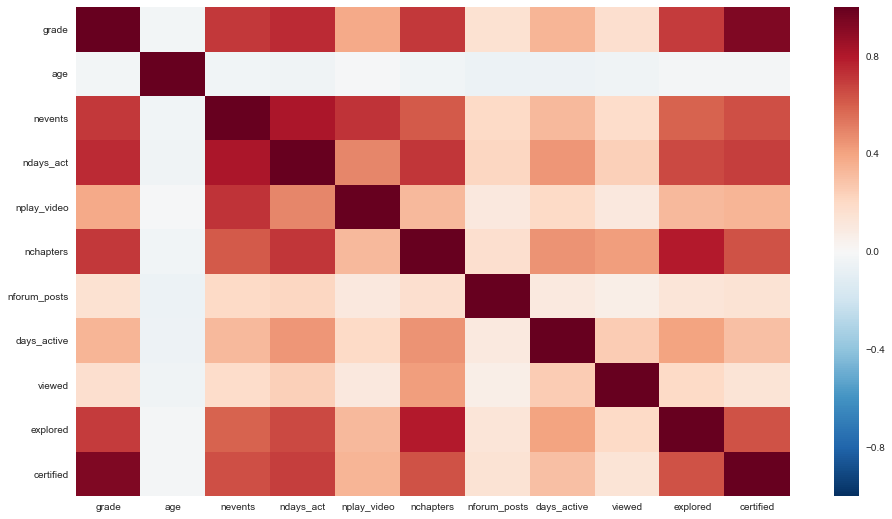

In [92]:
sns.heatmap(data[comparison_columns].corr())

In [93]:
data['certified'].value_counts(dropna= False)

0    566051
1     17687
Name: certified, dtype: int64

In [94]:
data = data.loc[data['nevents'] < 180000,] #droping noticed outlier before plotting

,slope,intercept,r_value,p_value,std_err
0,99.821054,-123.348109,0.835592,0.0,0.085895


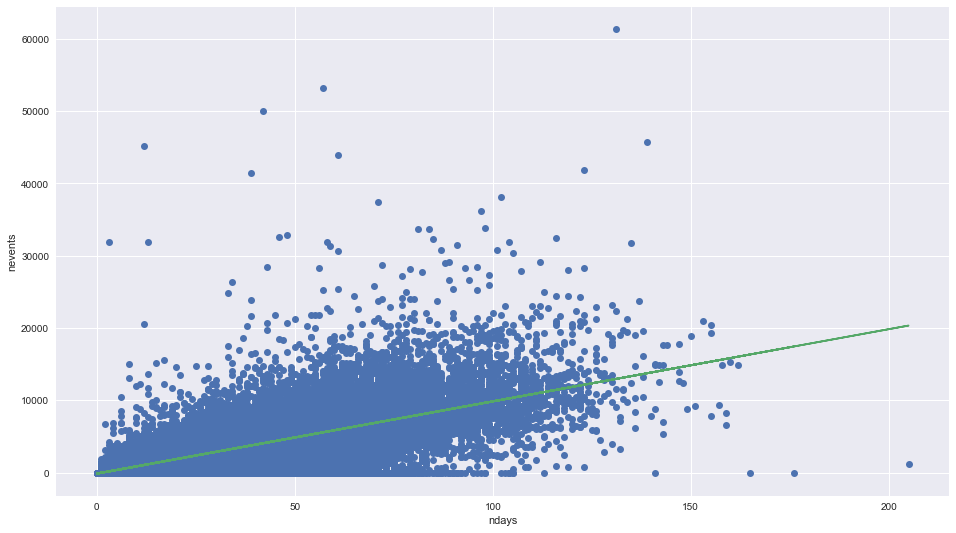

In [95]:
# plt.scatter(data['ndays_act'],data['nevents'])
plt.xlabel('ndays')
plt.ylabel('nevents')
slope, intercept, r_value, p_value, std_err = stats.linregress(data['ndays_act'],data['nevents'])
line = slope* data['ndays_act']+intercept

plt.plot(data['ndays_act'],data['nevents'],'o', data['ndays_act'], line)
res = pd.DataFrame([[slope, intercept, r_value, p_value, std_err]], columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err'])
res.head()

In [96]:
data.to_csv('data_set_cleaned.csv')

In [97]:
excluded_columns = ['course_id','userid_DI', 'final_cc_cname_DI', 'start_time_DI', 'last_event_DI', 'LoE_DI','YoB', 'gender','grade'] 
#columns that we didn't wanna drop from original data set but are excluded from X input for regression
#because we use their derivatives and columns that are excluded as not needed for regression

In [98]:
X, y = data.drop(excluded_columns, axis=1), data['grade']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [100]:
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('R2:', metrics.r2_score(y_test, predictions))

MSE: 0.00215268660204
RMSE: 0.0463970538078
MAE: 0.0155905718344
R2: 0.908425753842
